In [1]:
from bs4 import BeautifulSoup
from datetime import datetime
import requests
from IPython.display import clear_output
import time
import webbrowser
import numpy as np
import unicodedata
import pickle
import pandas as pd
import codecs
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import ttk

#Function to create time list
def ListofTime_generator(StartYear,StartMon,EndYear,EndMon):
    ListofTime = []
    while(StartYear!=EndYear or StartMon!=EndMon):
        ListofTime.append(str(StartYear) + "-" + str(StartMon).zfill(2))
        if StartMon == 12:
            StartYear += 1
            StartMon = 1
        else:
            StartMon += 1
    ListofTime.append(str(EndYear) + "-" + str(EndMon).zfill(2))
    return ListofTime

def HTMLrequest(ListofTime):
    #ListofTime = [] #200812 - 201903
    LinkHeader = "https://www.checkee.info/main.php?dispdate="
    AllPages = {}
    len_month = len(ListofTime)
    start_time = time.time()
    count = 1
    for months in ListofTime:
        clear_output()
        cur_time = time.time()
        print("requesting from " + LinkHeader + months)
        print("Progress: ",count,"/",len_month)
        print("time elapsed:",int(cur_time-start_time),"seconds")
        estimation = (cur_time-start_time)/count*(len_month-count)/60
        print("Estimate Time Left: %5.2f Minutes" % (estimation))
        session = requests.Session()
        page = session.get(LinkHeader + months, headers={'User-Agent': 'Mozilla/5.0'})
        AllPages[months] = page.content.decode("utf-8","ignore")
        count += 1
    return AllPages

#use strtmp for develope
class ApplicationCase():
    def __init__(self, ID):
        self.ID = ID
        self.VisaType = None
        self.VisaEntry = None
        self.Consulate = None
        self.Major = None
        self.CheckDate = None
        self.CompleteDate = None
        self.WaitingDays = None
        self.Comment = None
        self.Status = None

    def DebugPrint(self):
        if self.CompleteDate:
            print("----   This case is completed   ----")
        else:
            print("**** This case is not completed ****")
        print("ID            :",self.ID)
        print("Visa Type     :",self.VisaType)
        print("Visa Entry    :",self.VisaEntry)
        print("Consulate     :",self.Consulate)
        print("Major         :",self.Major)
        print("Status        :",self.Status)
        print("Check Date    :",self.CheckDate)
        print("Complete Date :",self.CompleteDate)
        print("Waiting Days  :",self.WaitingDays)
        print("Comment       :",self.Comment)
    def CasetoList(self):
        table = [self.ID,self.VisaType,self.VisaEntry,self.Consulate,self.Major,self.Status,self.CheckDate,self.CompleteDate,self.WaitingDays,self.Comment]
        return table
    def ComputeWaitingDays(self):
        if self.CompleteDate and self.CheckDate:
            self.WaitingDays = self.CompleteDate-self.CheckDate
        else: 
            return

#The struct of the data is organized in dictionary sorted by Months
#Return a list of applications
def ExtractDatafromHTML(AllPages):
    ApplicationofAll = {}
    for keys in AllPages.keys():
        clear_output()
        print("processing month",keys)
        #convert html page to beautifulsoup object
        pagetmp = AllPages[keys]
        soup = BeautifulSoup(pagetmp, 'html.parser')
        #There are 8 tables in the html
        #find the 6th table and extract it to be further analysised
        table = soup.find_all("table")
        count = 0
        for items in table:
            if count == 6:
                target = items
                break
            count+=1
        #In this table, separated case by case except item 0
        #item 0 contains the header of the table
        #so item 0 is poped in the program
        applications = target.find_all("tr")
        applications.pop(0)
        CasesofMonth = []
        for apps in applications:
            SingleCase = apps.find_all("td")
            SingleCase.pop(0)
            count = 0
            for items in SingleCase:
                #print(str(items)[4:-5])
                if count == 0:
                    AppTmp = ApplicationCase(str(items)[4:-5])
                elif count == 1:
                    AppTmp.VisaType = str(items)[4:-5]
                elif count == 2:
                    AppTmp.VisaEntry = str(items)[4:-5]
                elif count == 3:
                    AppTmp.Consulate = str(items)[4:-5]
                elif count == 4:
                    AppTmp.Major = str(items)[4:-5]
                elif count == 5:
                    AppTmp.Status = str(items)[4:-5]
                elif count == 6:
                    AppTmp.CheckDate = str(items)[4:-5]
                elif count == 7:
                    AppTmp.CompleteDate = str(items)[4:-5]
                elif count == 8:
                    AppTmp.WaitingDays = int(str(items)[4:-5])
                elif count == 9:
                    AppTmp.Comment = str(items)[74:-52]
                count += 1
            CasesofMonth.append(AppTmp)
        ApplicationofAll[keys] = CasesofMonth

    #converting dictionary to list
    APPLICATIONS_OF_ALL = []
    for keys in ApplicationofAll.keys():
        for items in ApplicationofAll[keys]:
            APPLICATIONS_OF_ALL.append(items.CasetoList())
    for items in APPLICATIONS_OF_ALL:
        items[6] = datetime.strptime(items[6], '%Y-%m-%d')
        if items[7] == "0000-00-00":
            items[7] = None
        else:
            items[7] = datetime.strptime(items[7], '%Y-%m-%d')
        if items[-1] == "":
            items[-1] = None
    return APPLICATIONS_OF_ALL

#converting list of applications to pandas data frame
def ListtoPandasFrame(APPLICATIONS_OF_ALL):
    #APPLICATIONS_OF_ALL to pandas data frame
    tabs = ["ID","VisaType","VisaEntry","Consulate","Major","Status","CheckDate","CompleteDate","WaitingDays","Comments"]
    ApplicationFrame = pd.DataFrame(APPLICATIONS_OF_ALL,columns=tabs)
    return ApplicationFrame

In [5]:
def center(e):
    w = int(root.winfo_width() / 3.5) # get root width and scale it ( in pixels )
    s = 'Checkee.info Data Analysis'.rjust(w//2)
    root.title(s)



root = Tk()
root.bind("<Configure>", center) # called when window resized
root.configure(background="black")

gui_style = ttk.Style()
gui_style.configure('My.TButton', foreground='#334353')
gui_style.configure('TAB.TFrame', background='grey')
gui_style.configure('text.TLabel', background='black',foreground="white")

tabControl = ttk.Notebook(root)
tabControl.pack(fill='both', expand='yes')
tab1 = ttk.Frame(root, style="TAB.TFrame")
tab2 = ttk.Frame(root)
tab2 = ttk.Frame(root, style="TAB.TFrame")
tab3 = ttk.Frame(root)
tab3 = ttk.Frame(root, style="TAB.TFrame")

tabControl.add(tab1, text='FetchData')
tabControl.add(tab2, text='InterestedData')
tabControl.add(tab3, text='Percentage')

#Label(tab1, image=photo1,bg="black").grid(row=0,column=0,sticky=W)
Label(tab1, text="Please Select the Time Range you are Interested:").grid(row=0,column=1,sticky=W)

root.mainloop()

In [6]:
StartYear,StartMon,EndYear,EndMon = 2008,12,2019,3
#flag for processing, if flag==1, download from online and save it to csv
#if flag==2, load data from csv file
flag = 2
if flag == 1:
    ListofTime = ListofTime_generator(StartYear,StartMon,EndYear,EndMon)
    AllPages = HTMLrequest(ListofTime)
    APPLICATIONS_OF_ALL = ExtractDatafromHTML(AllPages)
    ApplicationFrame = ListtoPandasFrame(APPLICATIONS_OF_ALL)
    ApplicationFrame.to_csv("./database/PandasApplicationData.csv", index = False, sep=',', encoding='utf-8')
elif flag == 2:
    ApplicationFrame = pd.read_csv("./database/PandasApplicationData.csv")

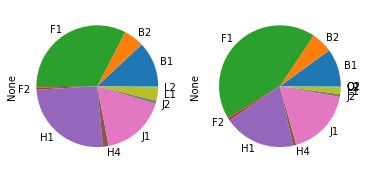

In [77]:
#ApplicationFrame.drop(na(subset = ["CompleteDate"]))
FinishedAppsFrame = ApplicationFrame[ApplicationFrame.Status == "Clear"]
FinishedAppsFrame = FinishedAppsFrame[FinishedAppsFrame.WaitingDays >0]
FinishedAppsFrame['Check_year_mon'] = FinishedAppsFrame.CheckDate.str.slice(start=0,stop=7)

LongCheckAppsFrame = FinishedAppsFrame[FinishedAppsFrame.WaitingDays >=60 ]
FAppsFrame = FinishedAppsFrame[FinishedAppsFrame.VisaType.str.slice(stop=1) == "F"]
HAppsFrame = FinishedAppsFrame[FinishedAppsFrame.VisaType.str.slice(stop=1) == "H"]
JAppsFrame = FinishedAppsFrame[FinishedAppsFrame.VisaType.str.slice(stop=1) == "J"]
BAppsFrame = FinishedAppsFrame[FinishedAppsFrame.VisaType.str.slice(stop=1) == "B"]
CommentsAppsFrame = ApplicationFrame.dropna(subset = ["Comments"])

#LongCheckAppsFrame.groupby("VisaType").min()[["WaitingDays"]]
#LongCheckAppsFrame.groupby("VisaType").max()[["WaitingDays"]]
#LongCheckAppsFrame.groupby("VisaType").mean()[["WaitingDays"]]
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

LongCheckAppsFrame.groupby("VisaType").size().plot(kind='pie',ax=ax1)
FinishedAppsFrame.groupby("VisaType").size().plot(kind='pie',ax=ax2)

In [78]:
# year FinishedAppsFrame.CheckDate.str.slice(start=0,stop=4)
# Mon FinishedAppsFrame.CheckDate.str.slice(start=5,stop=7)


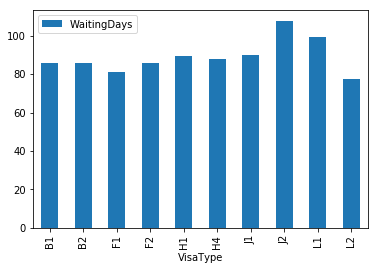

In [79]:
LongCheckAppsFrame.groupby("VisaType").mean()[["WaitingDays"]].plot(kind='bar')